<a href="https://colab.research.google.com/github/Zuhair0000/FYP-Research/blob/main/Research_Dataset_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Path to the clean India dataset
file_path = "/content/Dataset B/January 2024- June 2025.xlsx"

# Load the Excel file
india_df = pd.read_excel(file_path)

# Inspect first rows
print(india_df.head())
print(india_df.shape)

             Timestamp Demand (MW) Wind (MW) Solar (MW) Total Generation (MW)
0  01-01-2024 00:00:00   141981.26   9545.07      20.29             142193.38
1  01-01-2024 01:00:00   138675.49   9027.05      19.96             138792.04
2  01-01-2024 02:00:00   136122.78   8241.48      19.79             136796.02
3  01-01-2024 03:00:00   135806.51   7866.09      19.73             136859.67
4  01-01-2024 04:00:00   139905.77   7430.71      20.02             140561.49
(12990, 5)


In [3]:
# Convert Timestamp column to datetime
india_df["Timestamp"] = pd.to_datetime(india_df["Timestamp"], errors="coerce")

# Drop rows where Timestamp is missing
india_df = india_df.dropna(subset=["Timestamp"])

# Convert numeric columns (they may be read as strings)
num_cols = ["Demand (MW)", "Wind (MW)", "Solar (MW)", "Total Generation (MW)"]
for col in num_cols:
    india_df[col] = pd.to_numeric(india_df[col], errors="coerce")

# Sort chronologically
india_df = india_df.sort_values("Timestamp").reset_index(drop=True)

print(india_df.info())
print(india_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5184 entries, 0 to 5183
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Timestamp              5184 non-null   datetime64[ns]
 1   Demand (MW)            5184 non-null   float64       
 2   Wind (MW)              5184 non-null   float64       
 3   Solar (MW)             5184 non-null   float64       
 4   Total Generation (MW)  5184 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 202.6 KB
None
                 Timestamp    Demand (MW)     Wind (MW)    Solar (MW)  \
count                 5184    5184.000000   5184.000000   5184.000000   
mean   2024-10-21 00:50:00  192456.737118   8740.483189  15899.132461   
min    2024-01-01 00:00:00   97065.280000    636.000000    -49.270000   
25%    2024-05-06 23:45:00  182160.462500   4536.230000     96.275000   
50%    2024-09-21 23:30:00  195634.545000   7645.9

In [4]:
# Select subset of columns
india_df = india_df[["Timestamp", "Demand (MW)", "Wind (MW)", "Solar (MW)", "Total Generation (MW)"]]

print(india_df.head())

            Timestamp  Demand (MW)  Wind (MW)  Solar (MW)  \
0 2024-01-01 00:00:00    141981.26    9545.07       20.29   
1 2024-01-01 01:00:00    138675.49    9027.05       19.96   
2 2024-01-01 02:00:00    136122.78    8241.48       19.79   
3 2024-01-01 03:00:00    135806.51    7866.09       19.73   
4 2024-01-01 04:00:00    139905.77    7430.71       20.02   

   Total Generation (MW)  
0              142193.38  
1              138792.04  
2              136796.02  
3              136859.67  
4              140561.49  


In [5]:
# Drop missing or invalid values
india_df = india_df.dropna().reset_index(drop=True)

# Solar forecasting target
solar_features_b = ["Demand (MW)", "Wind (MW)"]  # predictors
target_solar_b   = "Solar (MW)"

# Wind forecasting target
wind_features_b = ["Demand (MW)", "Solar (MW)"]
target_wind_b   = "Wind (MW)"

X_solar_b = india_df[solar_features_b].values
y_solar_b = india_df[target_solar_b].values

X_wind_b = india_df[wind_features_b].values
y_wind_b = india_df[target_wind_b].values

In [6]:
# Scale features
scaler_solar_b = MinMaxScaler()
scaler_wind_b  = MinMaxScaler()

X_solar_b_scaled = scaler_solar_b.fit_transform(X_solar_b)
X_wind_b_scaled  = scaler_wind_b.fit_transform(X_wind_b)

y_solar_b_scaled = MinMaxScaler().fit_transform(y_solar_b.reshape(-1, 1)).flatten()
y_wind_b_scaled  = MinMaxScaler().fit_transform(y_wind_b.reshape(-1, 1)).flatten()

In [7]:
# Create sequences
def create_sequences(X, y, window=24):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

X_solar_b_seq, y_solar_b_seq = create_sequences(X_solar_b_scaled, y_solar_b_scaled)
X_wind_b_seq,  y_wind_b_seq  = create_sequences(X_wind_b_scaled,  y_wind_b_scaled)

In [8]:
def split_data(X, y, train_size=0.7, val_size=0.15):
    n = len(X)
    train_end = int(train_size * n)
    val_end = int((train_size + val_size) * n)
    return (
        X[:train_end], y[:train_end],
        X[train_end:val_end], y[train_end:val_end],
        X[val_end:], y[val_end:]
    )

X_train_solar_dl_b, y_train_solar_dl_b, X_val_solar_dl_b, y_val_solar_dl_b, X_test_solar_dl_b, y_test_solar_dl_b = split_data(X_solar_b_seq, y_solar_b_seq)
X_train_wind_dl_b,  y_train_wind_dl_b,  X_val_wind_dl_b,  y_val_wind_dl_b,  X_test_wind_dl_b,  y_test_wind_dl_b  = split_data(X_wind_b_seq, y_wind_b_seq)

In [9]:
# Flatten for ML models (2D)
X_train_solar_ml_b = X_train_solar_dl_b.reshape(X_train_solar_dl_b.shape[0], -1)
X_val_solar_ml_b   = X_val_solar_dl_b.reshape(X_val_solar_dl_b.shape[0], -1)
X_test_solar_ml_b  = X_test_solar_dl_b.reshape(X_test_solar_dl_b.shape[0], -1)

X_train_wind_ml_b = X_train_wind_dl_b.reshape(X_train_wind_dl_b.shape[0], -1)
X_val_wind_ml_b   = X_val_wind_dl_b.reshape(X_val_wind_dl_b.shape[0], -1)
X_test_wind_ml_b  = X_test_wind_dl_b.reshape(X_test_wind_dl_b.shape[0], -1)

### **ML for Solar**

In [10]:
def evaluate_model(y_true, y_pred, model_name, target_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    print(f"\n=== {model_name} Results for {target_name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    plt.figure(figsize=(10,5))
    plt.plot(y_true[:200], label="Actual", color="black")
    plt.plot(y_pred[:200], label=f"{model_name} Prediction", linestyle="--")
    plt.title(f"{target_name} Power Prediction ({model_name}) — Sample of 200 hours")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {"Model": model_name, "Target": target_name, "RMSE": rmse, "MAE": mae, "R2": r2}


=== Random Forest Results for Solar ===
RMSE: 0.2214
MAE : 0.1533
R²  : 0.6413


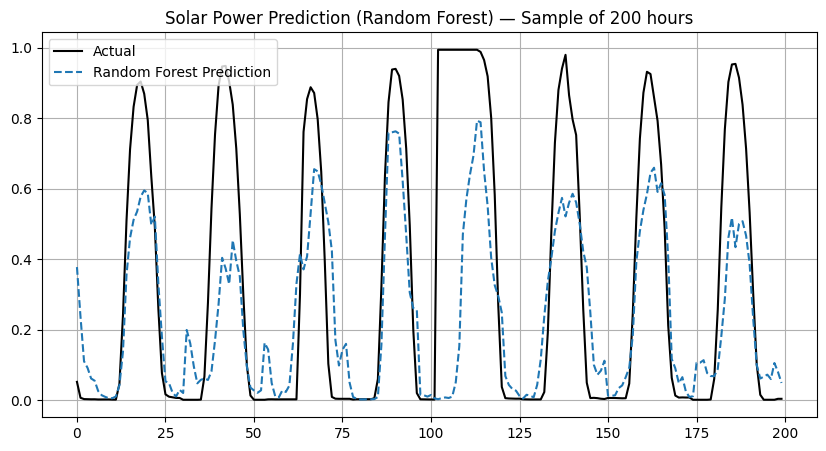

In [11]:
# --- Random Forest ---
rf_solar_b = RandomForestRegressor(n_estimators=200, random_state=42)
rf_solar_b.fit(X_train_solar_ml_b, y_train_solar_dl_b)
rf_solar_b_preds = rf_solar_b.predict(X_test_solar_ml_b)
rf_solar_b_results = evaluate_model(y_test_solar_dl_b, rf_solar_b_preds, "Random Forest", "Solar")


=== XGBoost Results for Solar ===
RMSE: 0.2056
MAE : 0.1360
R²  : 0.6908


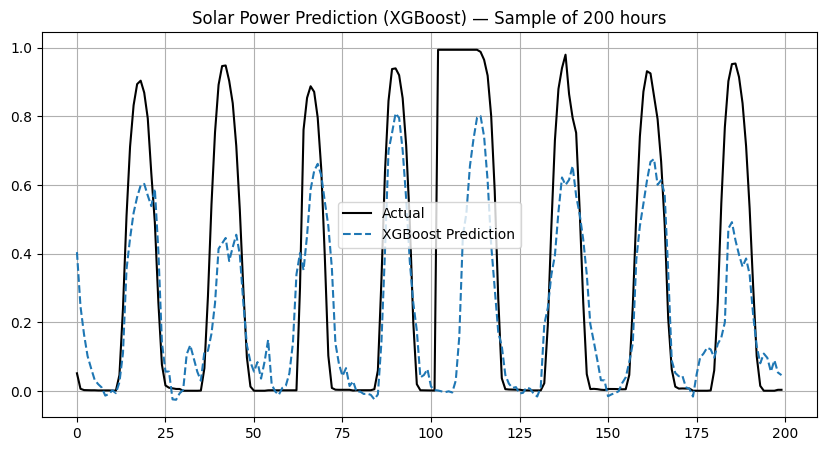

In [12]:
# --- XGBoost ---
xgb_solar_b = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_solar_b.fit(X_train_solar_ml_b, y_train_solar_dl_b,
                eval_set=[(X_val_solar_ml_b, y_val_solar_dl_b)],
                verbose=False)
xgb_solar_b_preds = xgb_solar_b.predict(X_test_solar_ml_b)
xgb_solar_b_results = evaluate_model(y_test_solar_dl_b, xgb_solar_b_preds, "XGBoost", "Solar")

### **ML for Wind**


=== Random Forest Results for Wind ===
RMSE: 0.1554
MAE : 0.1279
R²  : 0.2596


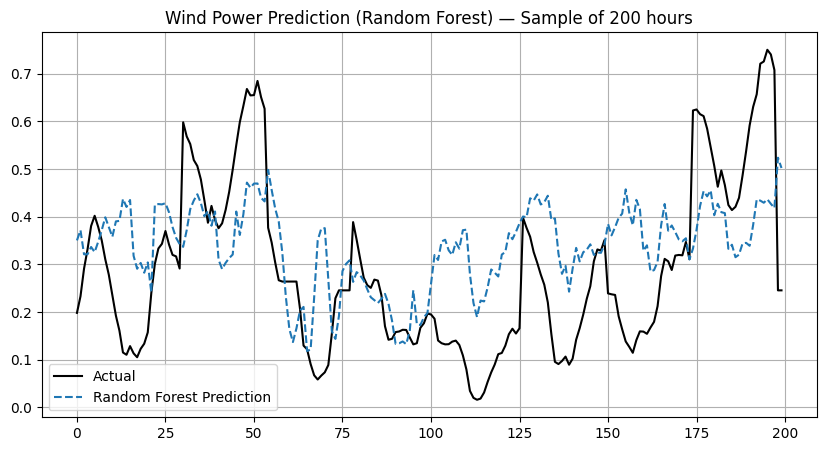

In [13]:
# --- Random Forest ---
rf_wind_b = RandomForestRegressor(n_estimators=200, random_state=42)
rf_wind_b.fit(X_train_wind_ml_b, y_train_wind_dl_b)
rf_wind_b_preds = rf_wind_b.predict(X_test_wind_ml_b)
rf_wind_b_results = evaluate_model(y_test_wind_dl_b, rf_wind_b_preds, "Random Forest", "Wind")


=== XGBoost Results for Wind ===
RMSE: 0.1840
MAE : 0.1439
R²  : -0.0377


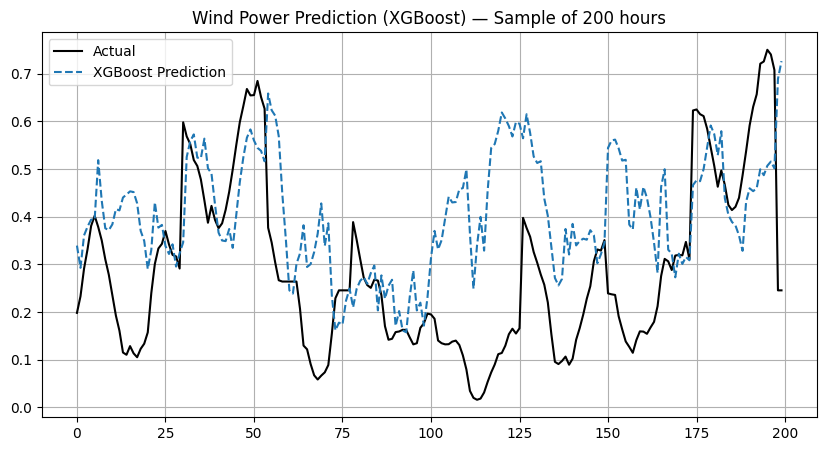

In [14]:

# --- XGBoost ---
xgb_wind_b = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_wind_b.fit(X_train_wind_ml_b, y_train_wind_dl_b,
               eval_set=[(X_val_wind_ml_b, y_val_wind_dl_b)],
               verbose=False)
xgb_wind_b_preds = xgb_wind_b.predict(X_test_wind_ml_b)
xgb_wind_b_results = evaluate_model(y_test_wind_dl_b, xgb_wind_b_preds, "XGBoost", "Wind")

### **DL for Solar**

In [15]:
def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [16]:
# --- LSTM ---
lstm_solar_b = build_lstm((X_train_solar_dl_b.shape[1], X_train_solar_dl_b.shape[2]))
history_lstm_solar_b = lstm_solar_b.fit(
    X_train_solar_dl_b, y_train_solar_dl_b,
    validation_data=(X_val_solar_dl_b, y_val_solar_dl_b),
    epochs=50, batch_size=32,
    callbacks=[early_stop], verbose=1
)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0848 - val_loss: 0.0947
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0392 - val_loss: 0.0890
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0290 - val_loss: 0.0727
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0232 - val_loss: 0.0767
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0200 - val_loss: 0.0742
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0169 - val_loss: 0.0668
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0145 - val_loss: 0.0679
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0141 - val_loss: 0.0705
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0128 - val_loss: 0.0775
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0116 - val_loss: 0.0652
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0104 - val_loss: 0.0559
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━

In [17]:
# --- GRU ---
gru_solar_b = build_gru((X_train_solar_dl_b.shape[1], X_train_solar_dl_b.shape[2]))
history_gru_solar_b = gru_solar_b.fit(
    X_train_solar_dl_b, y_train_solar_dl_b,
    validation_data=(X_val_solar_dl_b, y_val_solar_dl_b),
    epochs=50, batch_size=32,
    callbacks=[early_stop], verbose=1
)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0653 - val_loss: 0.0869
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0339 - val_loss: 0.0917
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0270 - val_loss: 0.0942
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0247 - val_loss: 0.0821
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0249 - val_loss: 0.0749
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0194 - val_loss: 0.0690
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0181 - val_loss: 0.0720
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0143 - val_loss: 0.0725
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0122 - val_loss: 0.0569
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0112 - val_loss: 0.0606
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0112 - val_loss: 0.0592
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 

### **DL for Wind**

In [18]:
# --- LSTM ---
lstm_wind_b = build_lstm((X_train_wind_dl_b.shape[1], X_train_wind_dl_b.shape[2]))
history_lstm_wind_b = lstm_wind_b.fit(
    X_train_wind_dl_b, y_train_wind_dl_b,
    validation_data=(X_val_wind_dl_b, y_val_wind_dl_b),
    epochs=50, batch_size=32,
    callbacks=[early_stop], verbose=1
)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0403 - val_loss: 0.0268
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0330 - val_loss: 0.0479
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0275 - val_loss: 0.0276
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0274 - val_loss: 0.0321
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0255 - val_loss: 0.0411
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0246 - val_loss: 0.0388
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0232 - val_loss: 0.0425
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0243 - val_loss: 0.0354
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0227 - val_loss: 0.0447
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0218 - val_loss: 0.0374
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0217 - val_loss: 0.0374


In [19]:
# --- GRU ---
gru_wind_b = build_gru((X_train_wind_dl_b.shape[1], X_train_wind_dl_b.shape[2]))
history_gru_wind_b = gru_wind_b.fit(
    X_train_wind_dl_b, y_train_wind_dl_b,
    validation_data=(X_val_wind_dl_b, y_val_wind_dl_b),
    epochs=50, batch_size=32,
    callbacks=[early_stop], verbose=1
)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0400 - val_loss: 0.0279
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0331 - val_loss: 0.0270
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0347 - val_loss: 0.0258
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0327 - val_loss: 0.0289
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0276 - val_loss: 0.0262
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0254 - val_loss: 0.0439
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0240 - val_loss: 0.0461
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0224 - val_loss: 0.0403
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0213 - val_loss: 0.0316
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0228 - val_loss: 0.0488
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0205 - val_loss: 0.0416
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 

### **Comparison**

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


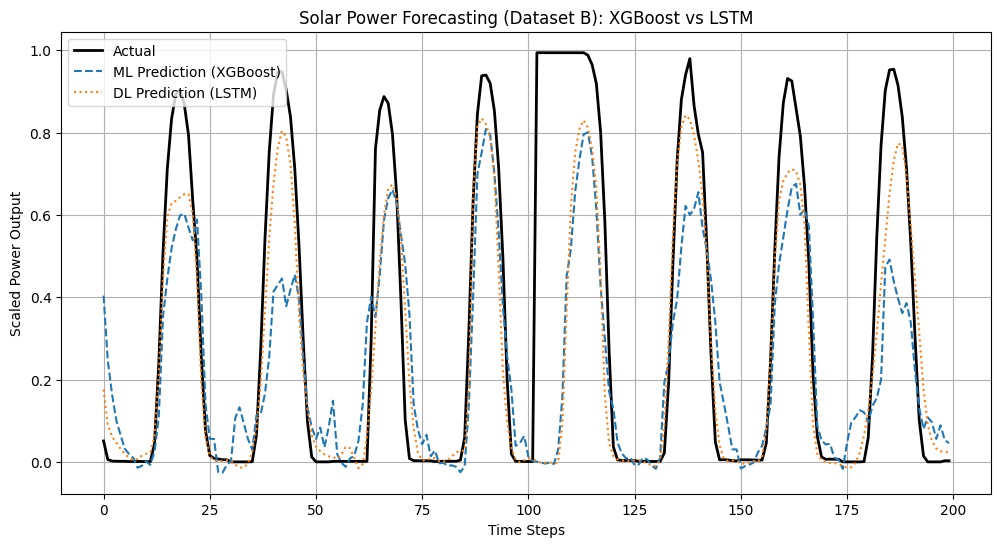

In [20]:
def plot_comparison(y_true, pred_ml, pred_dl, title, n=200):
    plt.figure(figsize=(12,6))
    plt.plot(y_true[:n], label="Actual", color="black", linewidth=2)
    plt.plot(pred_ml[:n], label="ML Prediction (XGBoost)", linestyle="--")
    plt.plot(pred_dl[:n], label="DL Prediction (LSTM)", linestyle=":")
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Scaled Power Output")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Solar Comparison
pred_ml_solar_b = xgb_solar_b.predict(X_test_solar_ml_b)
pred_dl_solar_b = lstm_solar_b.predict(X_test_solar_dl_b).flatten()

plot_comparison(y_test_solar_dl_b, pred_ml_solar_b, pred_dl_solar_b,
                "Solar Power Forecasting (Dataset B): XGBoost vs LSTM")

In [21]:
results_b = pd.DataFrame([
    rf_solar_b_results, xgb_solar_b_results,
    rf_wind_b_results,  xgb_wind_b_results
])

print("\n=== Dataset B (India) - ML Model Summary ===")
print(results_b)


=== Dataset B (India) - ML Model Summary ===
           Model Target      RMSE       MAE        R2
0  Random Forest  Solar  0.221444  0.153342  0.641334
1        XGBoost  Solar  0.205623  0.135985  0.690753
2  Random Forest   Wind  0.155440  0.127949  0.259598
3        XGBoost   Wind  0.184020  0.143890 -0.037708
